# Assigment 2: CAMSHIFT
## Paper
Lies das Paper "Bradski_etal_1998_camshift.pdf" im KVV (unter "Resources"). 

## Histogramm berechnen
* Implementiere eine Funktion, die ein Farbhistogramm erstellt. Übergebe entweder ein Bild und ein ROI, oder das dem ROI unterliegende Bild. 
* Hierzu ermögliche durch die Übergabe eines zweiten (bzw. dritten) Parameters die Zusammenfassung von Farbwerten in n Bins. 
* Lade das Bild "images/racecar.png" und konvertiere das Bild in den HSV-Farbraum. Plotte den Hue-Kanal. (**RESULT**)

4.0


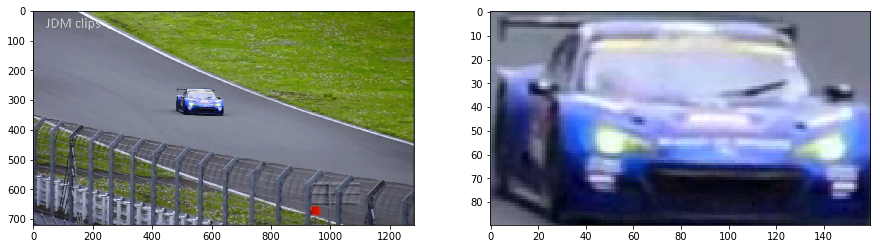

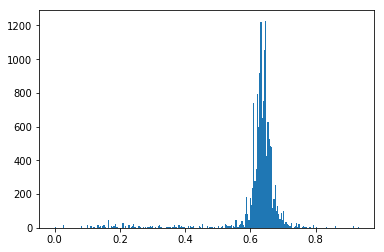

In [3]:
# dieser Code wurde als Musterlösung von Tobias Schülke zur Verfügung gestellt und von Tim renoviert

%matplotlib inline 
from skimage import io,color
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os
import warnings; warnings.simplefilter('ignore')

IMAGES_PER_ROW = 4

# MIN_SATURATION_CAR = 0.2
MIN_SATURATION_CAR = 0.3
MIN_VALUE_CAR = 0.5
MIN_SATURATION_TACO = 0.8
MIN_VALUE_TACO = 0.2

ROI_FRAME_MARGIN_CAR = 60
ROI_FRAME_MARGIN_TACO = 20

image = io.imread('images/racecar.png')
imageCar = image[260:350, 480:640]

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
# ...

ax1.imshow(image)
ax2.imshow(imageCar)

# ...

imageCarHSV = color.rgb2hsv(imageCar)

def createColorHistogram(img, binCount = 256, out = plt):
    colors = []
    for y in range (0, img.shape[1]):
        for x in range (0, img.shape[0]):
            colors.append(img[x,y,0])
    return out.hist(colors, binCount)[0]


plt.figure(2)
x = createColorHistogram(imageCarHSV)
print(x[255])

* stelle das Histogramm über dem Hue-Kanal für das gesamte Bild und für den Ausschnitt (x,y) = (480, 260) bis (640, 350) dar. Variiere auch mal testweise die Zahl der Bins(**RESULT**)


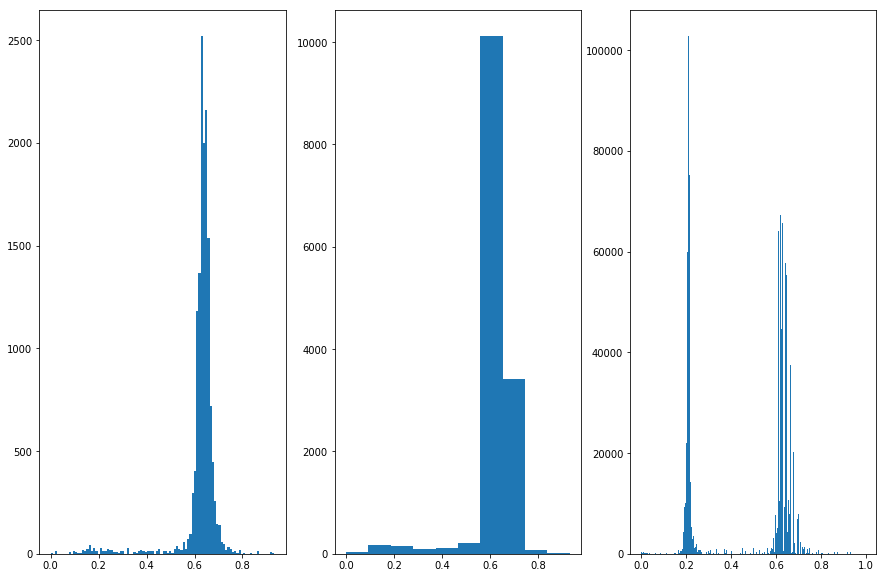

In [5]:
fig = plt.figure(1, figsize=(15, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
    
histCar100 = createColorHistogram(imageCarHSV, 100, ax1)
histCar10 = createColorHistogram(imageCarHSV, 10, ax2)

imageHSV = io.imread('images/racecar.png')
imageHSV = color.rgb2hsv(imageHSV)

histCar11 = createColorHistogram(imageHSV, 256, ax3)


## Wahrscheinlichkeitsverteilung
* implementiere die Methode aus der Vorlesung, die Dir - gegeben ein Hue-Histogramm - die Objekt-Wahrscheinlichkeitsverteilung für ein neues Bild berechnet. 
* erzeuge das Histogramm des Autos aus dem Bild "racecar.png" und wende die neue Funktion auf das letzte frame des Videos (images/racecar/151.jpg) an (**RESULT**)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

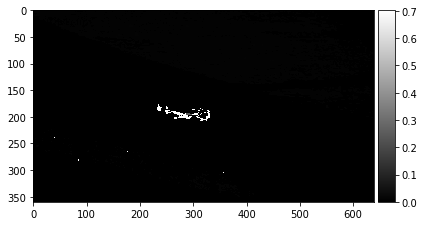

In [6]:
# Tip: in der Nacht sind alle Katzen grau ;)

# image in hsv
def createProbDistribution(image, objectHist, nbins, minSaturation, minValue):
    histTotal = np.sum(objectHist)
    probs = np.zeros_like(image[:, :, 0], dtype=np.float32)
    
    maxSaturation = 0.97
    maxValue = 0.97
    
    for y in range (0, image.shape[1]):
        for x in range (0, image.shape[0]):
            
            if image[x, y, 1] < minSaturation or image[x, y, 2] < minValue:
                continue
            
            if image[x, y, 1] > maxSaturation or image[x, y, 2] > maxValue:
                continue
            
            objectHistIndex = int(image[x, y, 0] * nbins)
            #if objectHistIndex > nbins-1:
            #    objectHistIndex = nbins-1
                
            amount = objectHist[objectHistIndex]
            probs[x,y] = amount/histTotal
            
    return probs

binCount = 10
lastFrame = io.imread('images/racecar/020.jpeg')
frameHsv = color.rgb2hsv(lastFrame)

histogramCar = createColorHistogram(imageCarHSV, binCount, ax1)
probDistr = createProbDistribution(frameHsv, histogramCar, binCount, MIN_SATURATION_CAR, MIN_VALUE_CAR)
io.imshow(probDistr, cmap='gray')

probDistr[0:10, 0]

### ROI auf Bild anzeigen


In [7]:
def drawROI(image, x, y, width, height, out = plt):
    currentAxis = plt.gca()
    currentAxis.add_patch(
        patches.Rectangle(
            (x, y),
            width,
            height,
            fill=False,
            edgecolor="yellow"
        )
    )
    
    out.imshow(image)


def getM00(probDistribution):
    return np.sum(probDistribution)


# drawROI(lastFrame, x, y, 160, 90)
# showRoiFrame(image, 480, 260, 160, 90)

##  Exercise 1.2 - Mean Shift
* Implementiere die Verschiebung und des ROI wie in der Vorlesung beschrieben. Teste den Algorithmus auf den Bildfolgen "images/racecar/*.jpg" oder "images/taco/*.jpg". Wähle das Tracking-Fenster geeignet (zur Reduktion der Dateigröße habe ich die Bilder um Faktor 2 verkleinert, d.h. die ROI von oben muss entsprechend angepasst werden). 
* Zeichne als Ausgabe die Trajektorie (die Bewegungsspur) der Objekte, wie durch CAMSHIFT zurückgegeben. (**RESULT**)

In [21]:
from skimage.draw import polygon_perimeter
from skimage.filters import gaussian

# M_SIZE_X = 160
# M_SIZE_Y = 80
# M_X = 320
# M_Y = 200# 

M_SIZE_X = 240
M_SIZE_Y = 120
M_X = 240
M_Y = 160

def getMeanWindowPos(probDistribution, mX, mY, mWidth, mHeight):
    height, width = probDistribution.shape

    winX1 = mX + mWidth if mX + mWidth < width else width-1
    winY1 = mY + mHeight if mY + mHeight < height else height-1
    
    cropped = probDistribution[mY:winY1, mX:winX1]
    smoothed = gaussian(cropped)
    m00 = getM00(smoothed) + 0.0000001
    print("M00: {}".format(m00))
    
    height, width = smoothed.shape
    xPos = 0
    yPos = 0
    
    for x in range (0, width):
        for y in range (0, height):
            prob = smoothed[y,x]
            xPos += x * prob
            yPos += y * prob
            
    return int(round(xPos / m00) - (mWidth/2)), int(round(yPos / m00) - (mHeight/2))


def meanShift(probDistr, px, py, M_SIZE_X, M_SIZE_Y):
    
    while True:
        wx,wy = getMeanWindowPos(probDistr, px, py, M_SIZE_X, M_SIZE_Y)
        px = px + wx
        py = py + wy
        # print(wx)
        if wx < 2 and wy < 2:
            return px,py

def get_file_name(i):
    if i < 10:
        return "images/racecar/00" + str(i) + ".jpeg"
    if i < 100:
        return "images/racecar/0" + str(i) + ".jpeg"
    return "images/racecar/" + str(i) + ".jpeg"

def draw_line(img, coord_list):
    if len(coord_list) < 2:
        return img
    
    coords = list(map(list, zip(*coord_list)))
    rr, cc = polygon_perimeter(coords[0], coords[1], img.shape, clip=False)
    img[cc,rr] = [0,0,255] # use [0,0,255,255] for test 3
    return img



0


M00: 2.716247468533958


M00: 2.208678475759121
M00: 2.621877798625125


M00: 2.439360556008839
M00: 3.9010015852678936


M00: 4.747426127968002
M00: 4.788737091957664


M00: 4.577940415667392
M00: 4.780857174972869


M00: 5.283047867136654
10
M00: 6.401035998861544


M00: 5.605726972639976


M00: 6.6807274515719905


M00: 7.906388949998898


M00: 10.894768059745383


M00: 9.593571032458197


M00: 9.098143383806892


M00: 9.696926632455323
M00: 8.75366835329541


M00: 6.626654745141139
20
M00: 9.391297986861236


M00: 11.77978478410155
M00: 16.02693288721579


M00: 17.869398954204648


M00: 20.197172186258477


M00: 16.533611570916065


M00: 15.097141907995256
M00: 18.990211755014116


M00: 17.657432470211894
M00: 19.735383180790972


30
M00: 19.218486516399402


M00: 21.26599371628611
M00: 21.44133080029125


M00: 23.555203951810313
M00: 24.371525356155264


M00: 27.57880870684836
M00: 26.786188423382974


M00: 23.335064179008963
M00: 23.675416795547857


M00: 18.168845023170505
40
M00: 15.429724142210153


M00: 22.180558031035197
M00: 15.403870144842797


M00: 21.914346413679766
M00: 25.00133362492639


M00: 21.599237873648224
M00: 56.75897508475029
M00: 19.363282503898287


M00: 58.68384200803464
M00: 21.340574926873973
M00: 63.29403917039962


KeyboardInterrupt: 

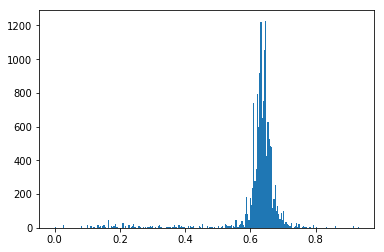

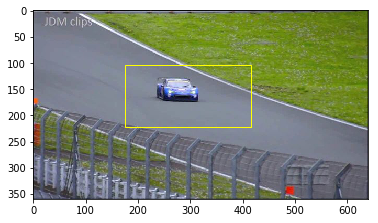

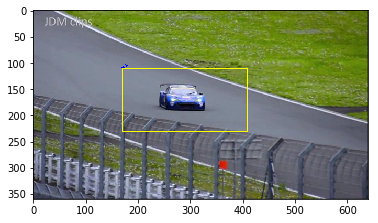

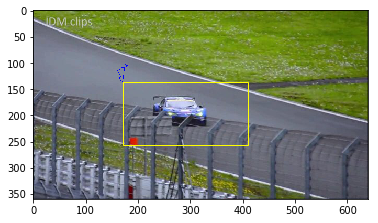

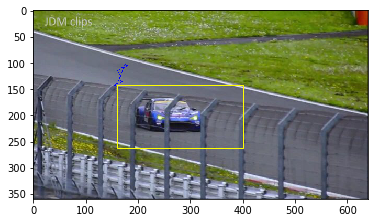

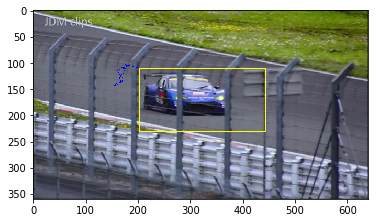

In [22]:

binCount = 256
histogramCar = createColorHistogram(imageCarHSV, binCount)

tracking_points = []

for i in range(0 ,151, 1):
    if i % 10 == 0:
        print(i)
        
    tmp_image = io.imread(get_file_name(i))
    tmp_image_hsv = color.rgb2hsv(tmp_image)
    
    tmpColorDistrib = createProbDistribution(tmp_image_hsv, histogramCar, binCount, MIN_SATURATION_CAR, MIN_VALUE_CAR)
    x,y = meanShift(tmpColorDistrib, M_X, M_Y, M_SIZE_X, M_SIZE_Y)
    
    tracking_points.append( (x, y) ) 
    
    if i % 10 == 0:
        plt.figure(i)
        drawROI(tmp_image, x, y, M_SIZE_X, M_SIZE_Y)
        tmp_image = draw_line(tmp_image, tracking_points)
        plt.imshow(tmp_image)




##  Exercise 1.2 - CAMSHIFT
* erweitere Deinen Algorithmus um die Anpassung der Größe des ROI und das Finden der Objektorientierung
* führe den Algorithmus wieder auf eine der Bildfolgen aus und zeichne eine Ellipse auf das Bild, die die gefundenen Parameter repräsentiert (**RESULT**)

0
M00: 5.630858411521979 / 2.372942985307902


w: 113, h: 57, ex: -8, ey: -20


M00: 4.45448287061897 / 2.110564585749266
w: 90, h: 45, ex: -6, ey: 5
M00: 4.791303695603376 / 2.1889046794237923
w: 96, h: 48, ex: -7, ey: -1
M00: 6.08798627613502 / 2.467384501072952
w: 122, h: 61, ex: -17, ey: -6


M00: 6.453697395156012 / 2.5404128395117223
w: 130, h: 65, ex: 0, ey: -1
M00: 5.564435467942961 / 2.358905565711133


w: 112, h: 56, ex: 13, ey: 8
M00: 5.550555697321364 / 2.3559617351139988
w: 112, h: 56, ex: 0, ey: 0
M00: 5.816111282852183 / 2.411661519129951


w: 117, h: 59, ex: -3, ey: -1
M00: 6.026458492298082 / 2.4548846189379416
w: 121, h: 61, ex: -4, ey: 0


M00: 6.0604862779720525 / 2.4618054914984757
w: 122, h: 61, ex: 0, ey: 0
M00: 5.540277918217875 / 2.353779496515737
w: 111, h: 56, ex: 3, ey: 5
M00: 5.540277918217874 / 2.3537794965157364
w: 111, h: 56, ex: 0, ey: 0


M00: 5.809514034596908 / 2.4102933503200203
w: 117, h: 59, ex: -4, ey: -1
10
M00: 6.7415973783055625 / 2.5964586224905575
w: 135, h: 68, ex: -7, ey: -1


M00: 6.023819610126487 / 2.454347084282597
w: 121, h: 61, ex: 3, ey: 3
M00: 6.023819610126487 / 2.454347084282597
w: 121, h: 61, ex: 0, ey: 0


M00: 6.685069614234783 / 2.5855501569752586
w: 134, h: 67, ex: -8, ey: 1


M00: 7.919375178665327 / 2.814138443407738
w: 159, h: 80, ex: -12, ey: 0


M00: 11.080902990622382 / 3.328799031275752
w: 222, h: 111, ex: -26, ey: -12


M00: 9.646333266755963 / 3.1058546757303316
w: 193, h: 97, ex: 12, ey: 9
M00: 9.575955103648388 / 3.094504015775127
w: 192, h: 96, ex: 0, ey: 1


M00: 9.214651862647852 / 3.035564504774664
w: 185, h: 93, ex: 0, ey: 1


M00: 9.932563772159432 / 3.1515970193156724
w: 199, h: 100, ex: -3, ey: 0


M00: 9.488914565729866 / 3.0804081816749327
w: 190, h: 95, ex: 0, ey: 3
M00: 9.438055745936401 / 3.0721418824553663
w: 189, h: 95, ex: 0, ey: 1


M00: 7.092030836709006 / 2.6630867122024036
w: 142, h: 71, ex: 24, ey: 13
M00: 7.083472401834263 / 2.6614793634056726
w: 142, h: 71, ex: 0, ey: 0
20


M00: 10.048541860101215 / 3.1699435105536526
w: 201, h: 101, ex: -23, ey: -11


M00: 13.407904632789359 / 3.6616805749258576
w: 269, h: 135, ex: -40, ey: -18
M00: 17.34400457527968 / 4.164613376446808


w: 347, h: 174, ex: -35, ey: -19
M00: 18.967873363994407 / 4.35521220653993


w: 380, h: 190, ex: -11, ey: -6
M00: 24.451238362649697 / 4.944819345805233


w: 490, h: 245, ex: -65, ey: -27
M00: 24.73499708635925 / 4.973429107402582


w: 495, h: 248, ex: 3, ey: -8
M00: 25.2385555580742 / 5.023798916962561
w: 505, h: 253, ex: -3, ey: -6


M00: 25.628502419400633 / 5.062460115339244
w: 513, h: 257, ex: -3, ey: -7


M00: 30.5856849081364 / 5.530432614916884
w: 612, h: 306, ex: -50, ey: -22


ValueError: zero-size array to reduction operation minimum which has no identity

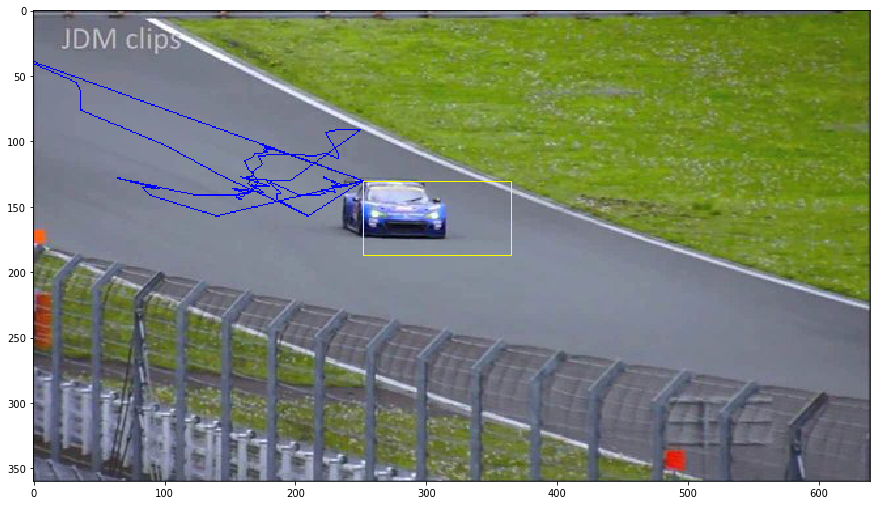

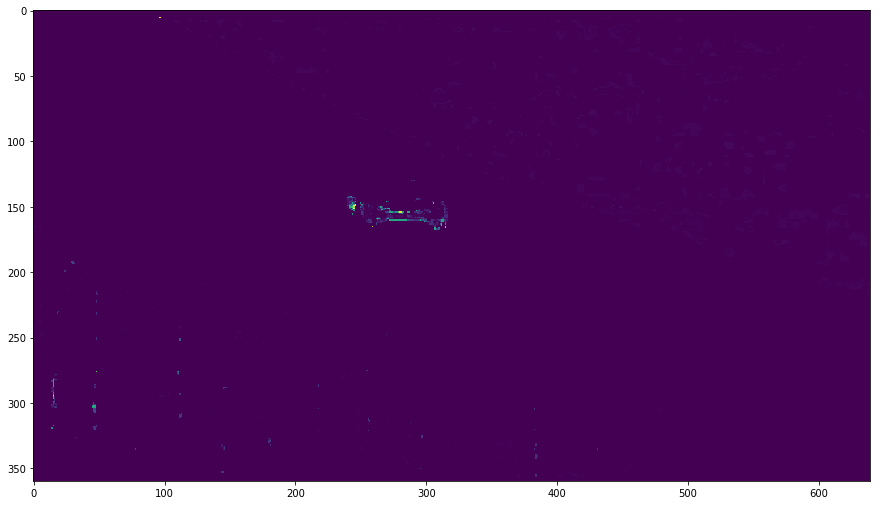

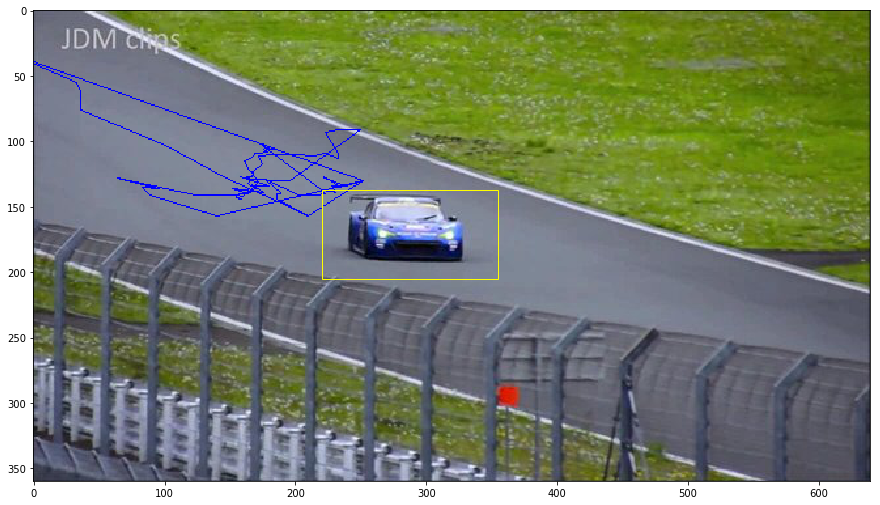

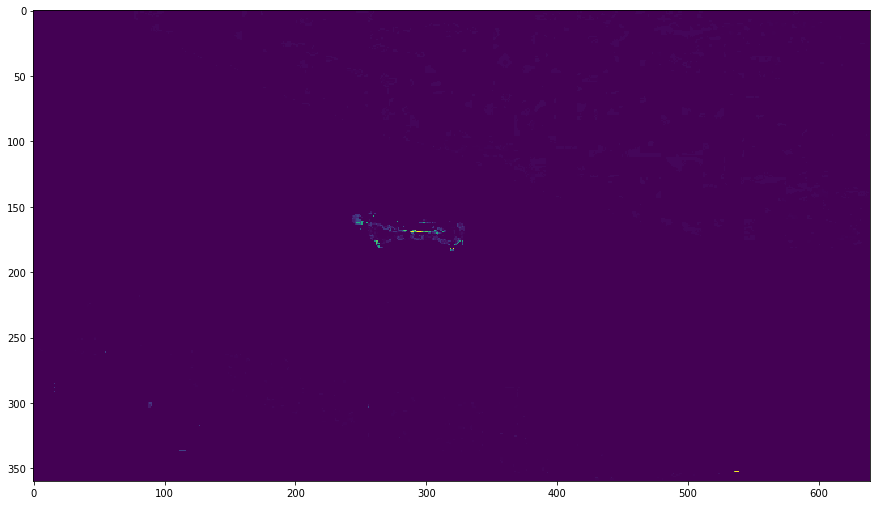

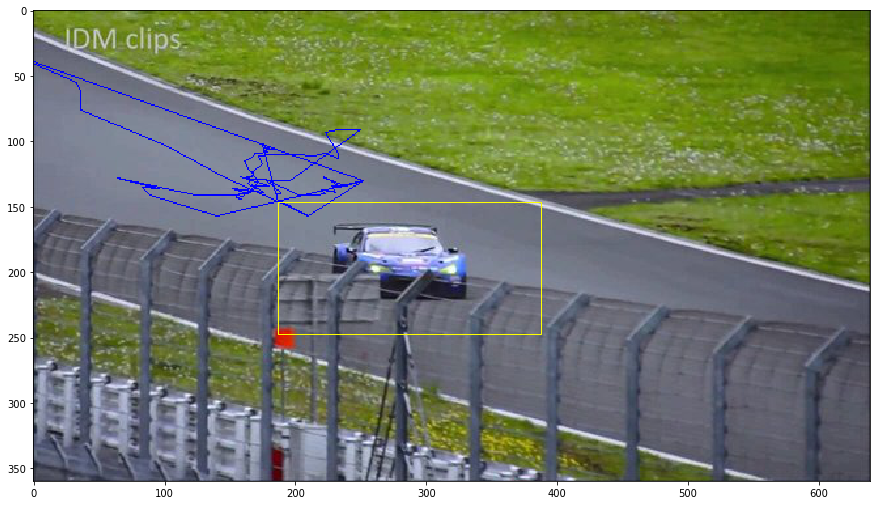

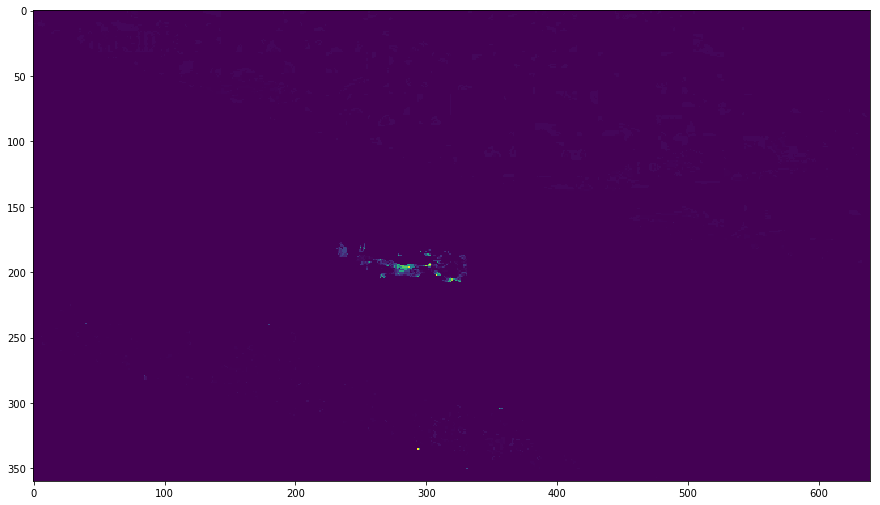

In [26]:
import math

# s = 2 * sqrt( M00 / 256 )

def getCamWindowPos(probDistribution, mX, mY, mWidth, mHeight):
    height, width = probDistribution.shape

    winX1 = mX + mWidth if mX + mWidth < width else width-1
    winY1 = mY + mHeight if mY + mHeight < height else height-1
    
    cropped = probDistribution[mY:winY1, mX:winX1]
    smoothed = gaussian(cropped)
    m00 = getM00(smoothed) + 0.0000001
    print("M00: {} / {}".format(m00,  math.sqrt(m00)))
    
    newHeight = 10 * m00
    newWidth = 2 * newHeight
    
    height, width = smoothed.shape
    xPos = 0
    yPos = 0
    
    for x in range (0, width):
        for y in range (0, height):
            prob = smoothed[y,x]
            xPos += x * prob
            yPos += y * prob
            
    return int(round(xPos / m00) - (newWidth/2)), int(round(yPos / m00) - (newHeight/2)), \
           int(math.ceil(newWidth)), int(math.ceil(newHeight))


def camShift(probDistr, px, py, M_SIZE_X, M_SIZE_Y):
    
    prev = 0
    wwidth = M_SIZE_X + 20
    wheight = M_SIZE_Y + 20
    
    while True:
        wx, wy, wwidth, wheight = getCamWindowPos(probDistr, px, py, wwidth, wheight)
        px = px + wx
        py = py + wy
        print("w: {}, h: {}, ex: {}, ey: {}".format(wwidth, wheight, wx, wy))
        
        if wx < 2 and wy < 2:
            return px, py, wwidth, wheight
        
        prev = wwidth

prevX = None
prevY = None
prevW = None
prevH = None

for i in range(0, 151, 1):
    if i % 10 == 0:
        print(i)
        
    tmp_image = io.imread(get_file_name(i))
    tmp_image_hsv = color.rgb2hsv(tmp_image)
    
    tmpColorDistrib = createProbDistribution(tmp_image_hsv, histogramCar, binCount, MIN_SATURATION_CAR, MIN_VALUE_CAR)
    
    if not prevX:
        x, y, width, height = camShift(tmpColorDistrib, 260, 150, M_SIZE_X, M_SIZE_Y)
        prevX = x
        prevY = y
        prevW = width
        prevH = height
        
    else:
        x, y, width, height = camShift(tmpColorDistrib, prevX, prevY, prevW, prevH)
        prevX = x
        prevY = y
        prevW = width
        prevH = height
    
    tracking_points.append( (prevX, prevY) ) 
    
    if i % 10 == 0:
        plt.figure(2*i, figsize=(15,20))
        drawROI(tmp_image, prevX, prevY, prevW, prevH)
        tmp_image = draw_line(tmp_image, tracking_points)
        plt.imshow(tmp_image)
    
        plt.figure(2*i+1, figsize=(15,20))
        plt.imshow(tmpColorDistrib)